# UE22CS342AA2: Data Analytics - Worksheet 3a
# Time Series Analysis and Forecasting Techniques

Designed by Anshul Ranjan, Dept.of CSE - itsanshulranjan@gmail.com

## Student Details

• Name : Mohul Y P

• SRN : PES1UG22CS360

• Section : F

## Air Passengers Analysis
Imagine you're optimizing airline services. \
You've been given a dataset, your task is to analyze monthly trends in air passenger numbers to inform decisions such as route planning, pricing strategies, and enhancing the overall travel experience.

### Contents of the worksheet

It is suggested to have a grip on the theoretical concepts of:

* Components of time series data 
* Decomposition of time series data
* Exponential Smoothing techniques
* Stationary Signals, Dickey-fuller test and Differencing
* Forecasting with AR, MA, ARMA
* Autocorrelation (ACF, PACF) and ARIMA
* Seasonality in Time Series and SARIMA

### Dataset

The data is provided in the AirPassengers.csv file. The data dictionary is as follows:

* Month: The month of the year (formatted as 'YYYY-MM') during which passenger data was collected.
* Passengers: The number of air passengers recorded during that month.

The target variable is **Passengers**, which we shall analyze and forecast in this worksheet. Understanding the trends and patterns in air passenger data is crucial for airline route planning, pricing strategies, capacity management, and enhancing the overall travel experience. Accurately predicting passenger volumes aids in optimizing resources, scheduling, and making informed decisions to meet market demands and improve service quality.

In [2]:
# Load necessary libraries
library(dplyr) 
library(tidyr)  
library(ggplot2) 

options(warn=-1)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Data Ingestion and Preprocessing
• Reading this file into a data.frame object

In [3]:
# Read the CSV file
df <- read.csv('/kaggle/input/flight-attendees/AirPassengers.csv')

# Display information about the data frame
str(df)

'data.frame':	144 obs. of  2 variables:
 $ Month       : chr  "1949-01" "1949-02" "1949-03" "1949-04" ...
 $ X.Passengers: int  112 118 132 129 121 135 148 148 136 119 ...


In [4]:
head(df)

Month   X.Passengers
1 1949-01 112         
2 1949-02 118         
3 1949-03 132         
4 1949-04 129         
5 1949-05 121         
6 1949-06 135

The class (data type) of each column in the data frame

In [5]:
sapply(df, class)

Month X.Passengers 
 "character"    "integer"

In [6]:
# Convert 'Month' to Date type
df$Month <- as.Date(paste0(df$Month, "-01"), format="%Y-%m-%d")

# Check the data types of the columns
sapply(df, class)

Month X.Passengers 
      "Date"    "integer"

In [7]:
length(unique(df$Month))

[1] 144

In [8]:
# Rename columns
df <- df %>% rename(value = X.Passengers, month = Month)
head(df)

month      value
1 1949-01-01 112  
2 1949-02-01 118  
3 1949-03-01 132  
4 1949-04-01 129  
5 1949-05-01 121  
6 1949-06-01 135

Setting the 'Month' column as the index of the DataFrame to organize the data by time, then plotting the data to visualize the trend in passenger numbers over the given months.

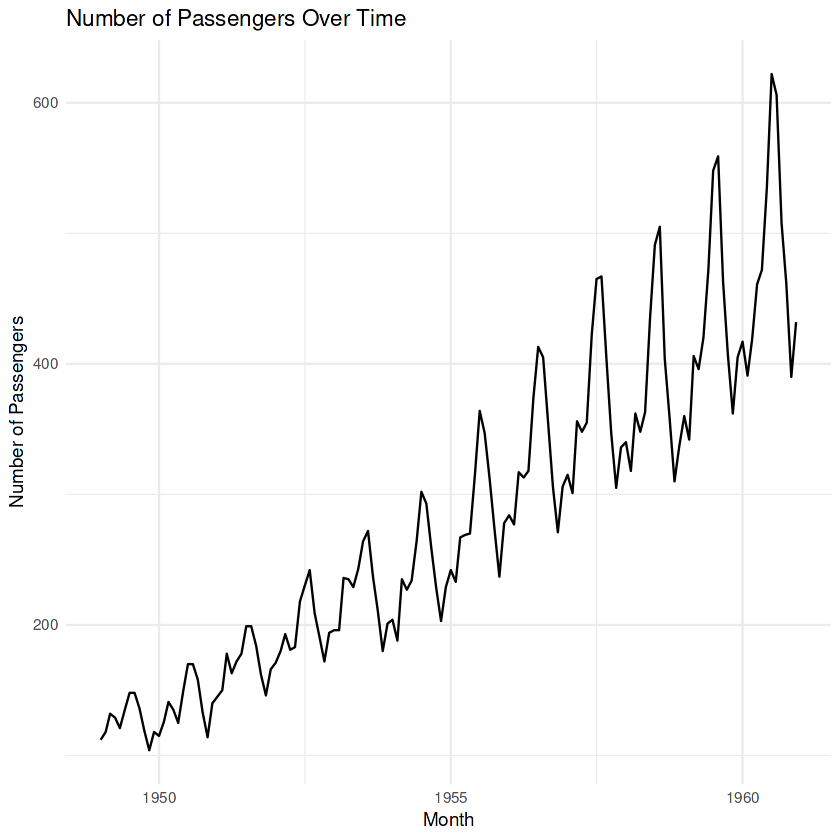

In [9]:
# Set 'month' as the index (not strictly necessary in R but useful for plotting)
df <- df %>% arrange(month)

# Plot the data
ggplot(df, aes(x = month, y = value)) +
  geom_line() +
  labs(title = "Number of Passengers Over Time", x = "Month", y = "Number of Passengers") +
  theme_minimal()

Applying a 12-month rolling average to the 'value' column to smooth out short-term fluctuations and highlight longer-term trends, then plotting this smoothed data with 'Date' as the x-axis label for better visualization.


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




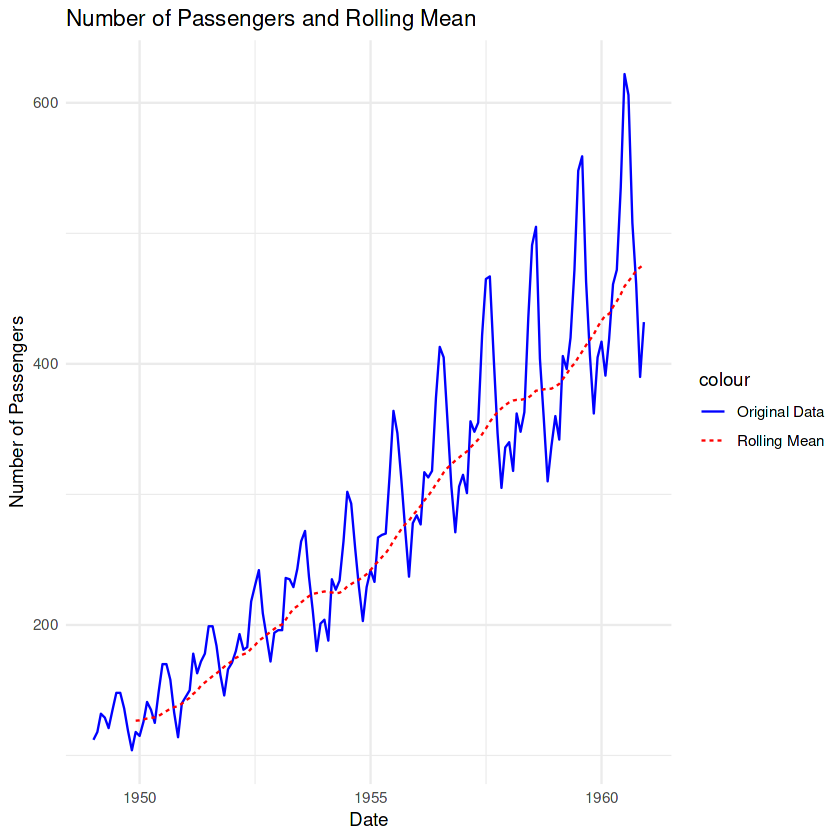

In [10]:
library(zoo)

# Calculate the rolling mean
df$rolling_mean <- rollmean(df$value, k = 12, fill = NA, align = "right")

# Plot the rolling mean
ggplot(df, aes(x = month)) +
  geom_line(aes(y = value, color = "Original Data")) +
  geom_line(aes(y = rolling_mean, color = "Rolling Mean"), linetype = "dashed") +
  labs(title = "Number of Passengers and Rolling Mean",
       x = "Date",
       y = "Number of Passengers") +
  theme_minimal() +
  scale_color_manual(values = c("Original Data" = "blue", "Rolling Mean" = "red"))


## Stationarity
• Testing for stationarity \
– We can use the Augmented Dickey-Fuller test (ADF) to test the time series for stationarity

Question 3.1: What are the null hypothesis and alternate hypothesis in this case?

* H0: series is non-stationary
* H1: time series is stationary

Question 3.2: What are you doing by performing the Augmented Dickey-Fuller (ADF) test on the 'value' column, and how do you interpret the ADF statistic and p-value to determine if the data is stationary?

ADF is a hypothesis test to test whether the coefficients of AR process are <1. 

If the ADF statistic is less than the critical value, the data is stationary.
If the ADF statistic is higher than the critical value, the data is non-stationary. Basically we retain NULL hypothesis.

Question 3.3: Write the code to perform the Augmented Dickey-Fuller (ADF) test on the 'value' column of the DataFrame df to check for stationarity. After running the code, determine whether the data is stationary based on the p-value.

 > Hint : Check the tseries library to perform the test (adf function)
 > * Don't Forget to perform this y <- diffinv(x) before the adf test check the docs here - https://cran.r-project.org/web/packages/tseries/tseries.pdf
 > * https://uribo.github.io/rpkg_showcase/date_and_time/tseries.html
 > * https://rdrr.io/cran/tseries/

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 




	Augmented Dickey-Fuller Test

data:  y
Dickey-Fuller = 2.6449, Lag order = 5, p-value = 0.99
alternative hypothesis: stationary


Original length: 144
Length after reconstruction: 145

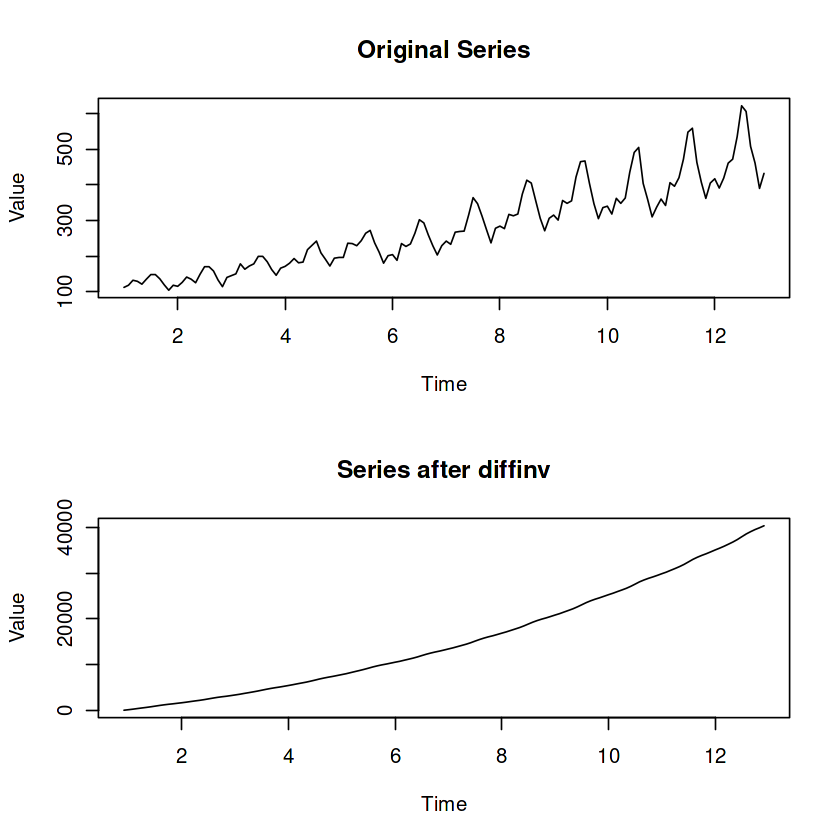

In [11]:
library(tseries)
ts_data <- ts(df$value, frequency=12)
ts_data_clean <- na.omit(ts_data)
y <- diffinv(ts_data_clean)  
adf_result <- adf.test(y)
print(adf_result)
par(mfrow=c(2,1))
plot(ts_data_clean, main="Original Series", ylab="Value")
plot(y, main="Series after diffinv", ylab="Value")

# Print lengths to verify
cat("\nOriginal length:", length(ts_data_clean))
cat("\nLength after reconstruction:", length(y))

• If the data is not stationary, and if we intend to use a model like ARIMA, the data has to
be transformed. \
• Two most common methods to transform series to stationary are:

* Transformations: eg. log or square root or combinations of these transformations to
stabilize non-constant variance.
* Differencing: subtract current value from previous (with a certain degree)

Check this out for more information, and an implementation in Python!: \
https://www.kaggle.com/code/rdizzl3/time-series-transformations

## Inference

p value is 0.99 which is >0.05, so we retain null hypothesis. the data is non stationary.

Question 3.4: Create a new dataframe using suitable differencing order, to convert the data
to stationary time series. 
 > Hint: You can use the same function to confirm the time series is stationary after transformation.

Try to perform first order differencing and observe how the values changes (ADF statistic and p-value), also observe the change in ACF and PACF plots \
Always try to plot the graphs before making the final decision


	Augmented Dickey-Fuller Test

data:  diff_data
Dickey-Fuller = -7.0177, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary



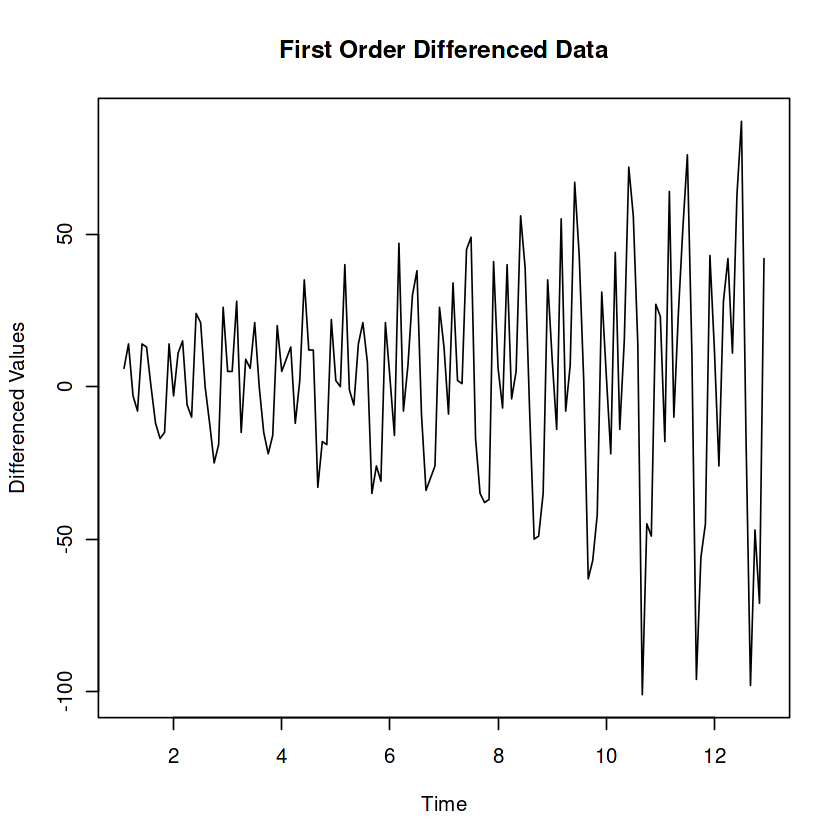

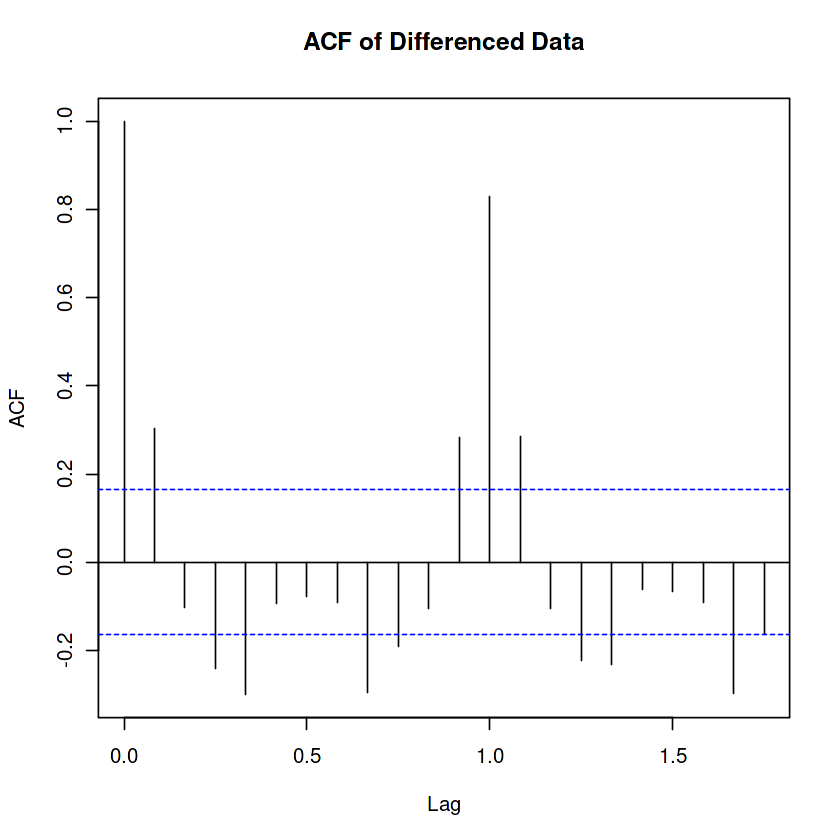

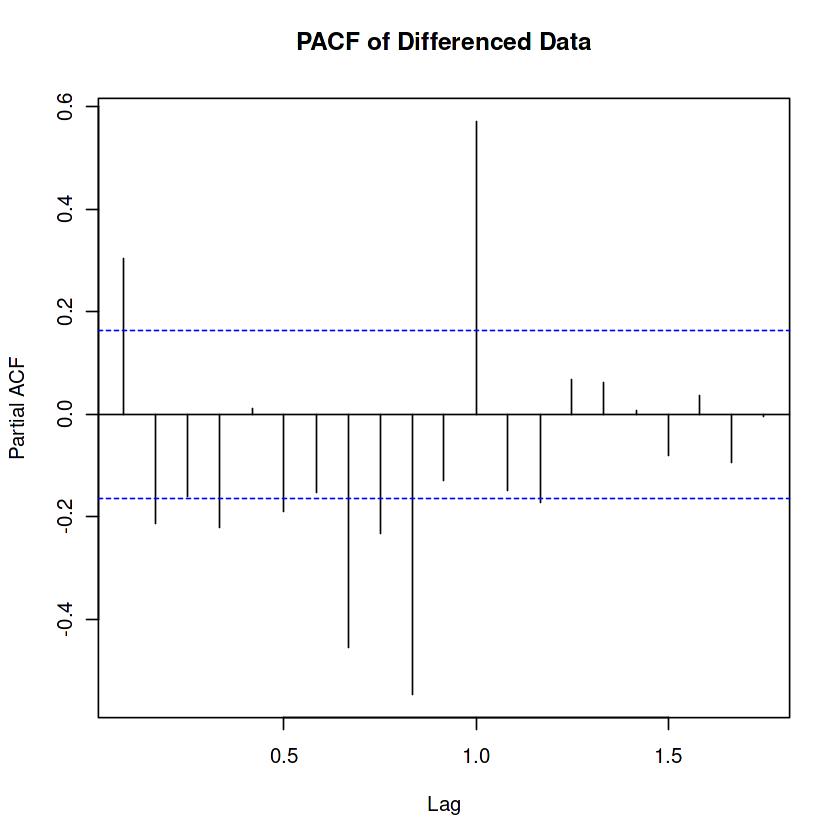

In [12]:
diff_data <- diff(ts_data, differences=1)

plot(diff_data, main="First Order Differenced Data", ylab="Differenced Values")

adf_result_diff <- adf.test(diff_data)
print(adf_result_diff)

acf(diff_data, main="ACF of Differenced Data")
pacf(diff_data, main="PACF of Differenced Data")

## Inference
after performing first order differencing in 3.4, we see that the p value<0.05 and so we reject null hypothesis. Data is stationary

## Autocorrelation Analysis
• We will experiment and plot two functions: 
* **ACF (Autocorrelation function)**: The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number
of periods or units.
* **PACF (Partial Autocorrelation function)**: Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

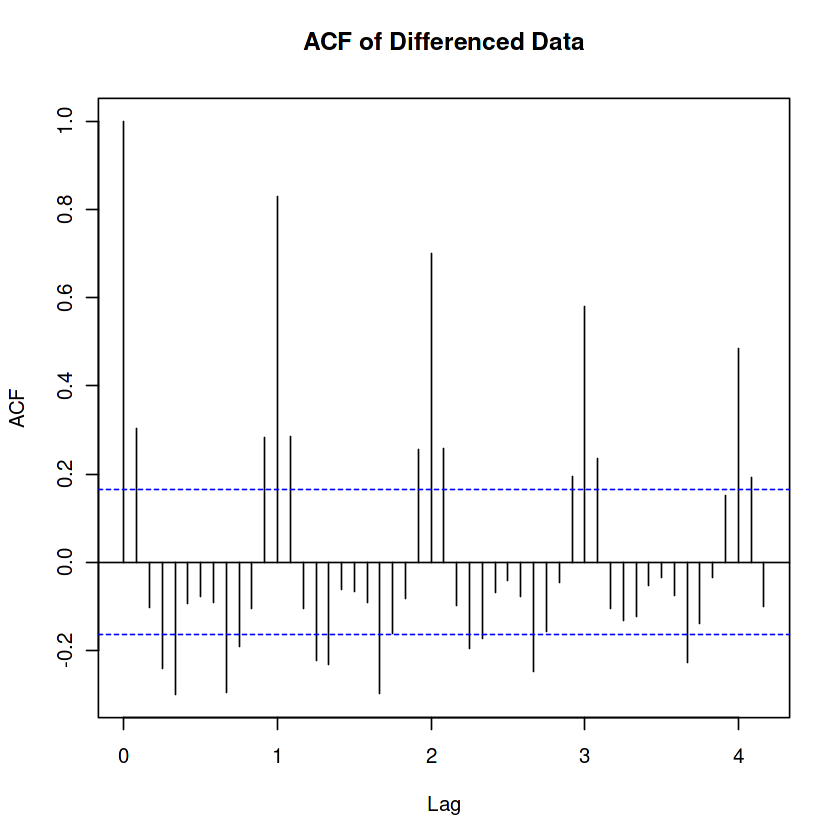

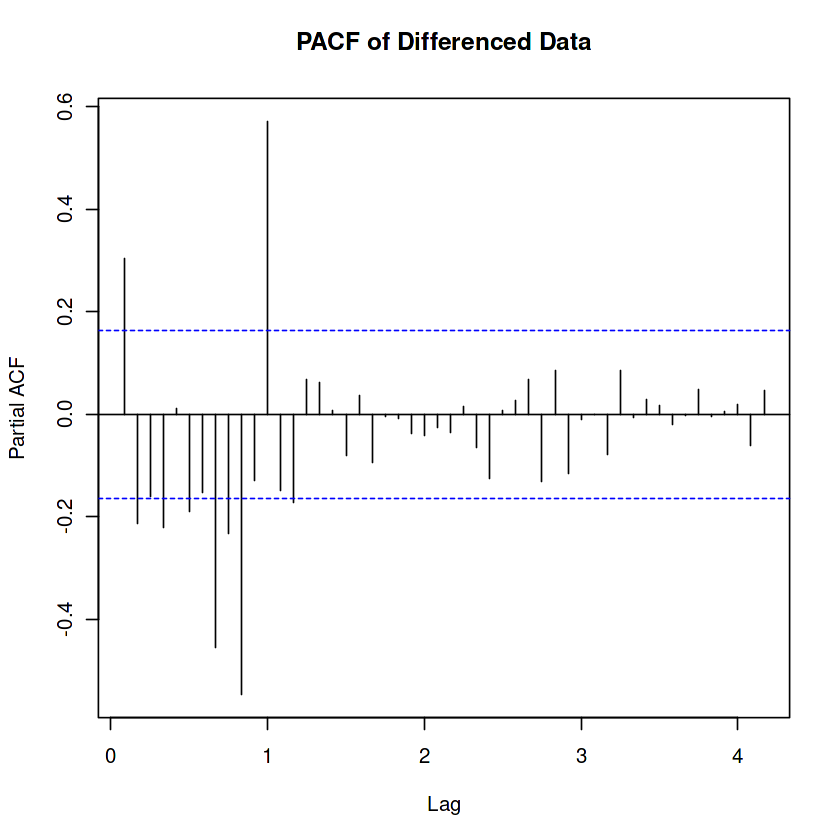

In [14]:
library(stats)
acf_result <- acf(diff_data, lag.max = 50, main = "ACF of Differenced Data")
pacf_result <- pacf(diff_data, lag.max = 50, main = "PACF of Differenced Data")

Question 3.5 : What are the values of p, q and d? How did you come to this conclusion,
looking at the ACF, PACF plots? \
> Hint: The value of d is decided by the order of differencing, as transformed in the previous
section.

Based on the ACF and PACF plots:

d = 1 because first-order differencing was needed to make the series stationary
p = 1 because after 1 lag the value cuts off to 0 in pacf
q = 2 because after 1 lag the value cuts off to 0 in acf

## Decomposition

Question 3.6: 
1. Decompose the **value** column into the constituent components, and plot them. 
2. Which model of time series did you use for decomposition, and why? (between additive and multiplicative models)

> Hint: The data is Sesonal, Look at the decompose function in stats library.

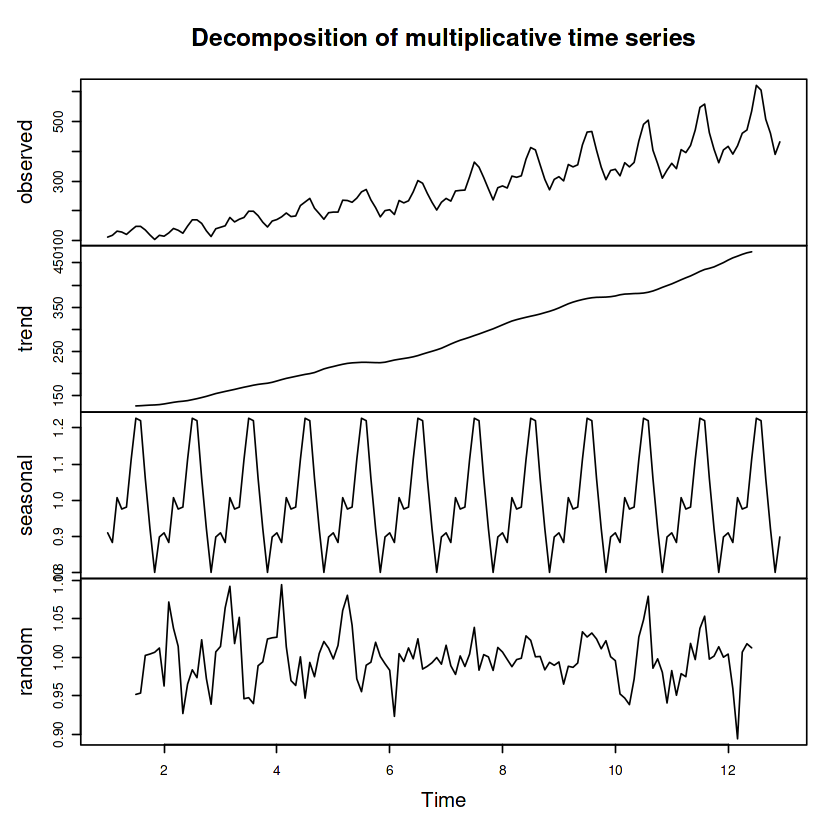

In [15]:
ts_data <- ts(df$value, frequency=12)
decomp <- decompose(ts_data, type="multiplicative")
plot(decomp)


### why did i chose multiplicative?
we chose multiplicative model as because the spikes get bigger as we go up in the original, observed data

Note: Sometimes, we look at upsampling or downsampling the data. For instance, if we
have sensor data for each second, we might not need such granular data, and we
downsample the data to daily data or hourly data or so.
Explore further here: https://machinelearningmastery.com/resample-interpolatetime-series-data-python/

You can also explore adding the decomposed versions of each feature (column) to your data, and utilize it
as exogenous variables for multivariate forecasting! This would require you to decompose all features, such
as temperature, rainfall, etc. as well, which is out of scope of this worksheet.

## Exponential Smoothing

Question 3.7:

• Perform forecasts using Single, Double and Triple Exponential Smoothing. \
• Plot forecasts of all three forecasts (using different colors), against the true values. (Use lines) \
• Only one function needed for all three forecasts, only requiring you to change the parameters to get each of the 3 models. \
• Hint: look at the ExponentialSmoothing function \
• Go ahead, and experiment with the values of alpha, beta and gamma and see how the forecast changes.

> Hint: Use the forecast library

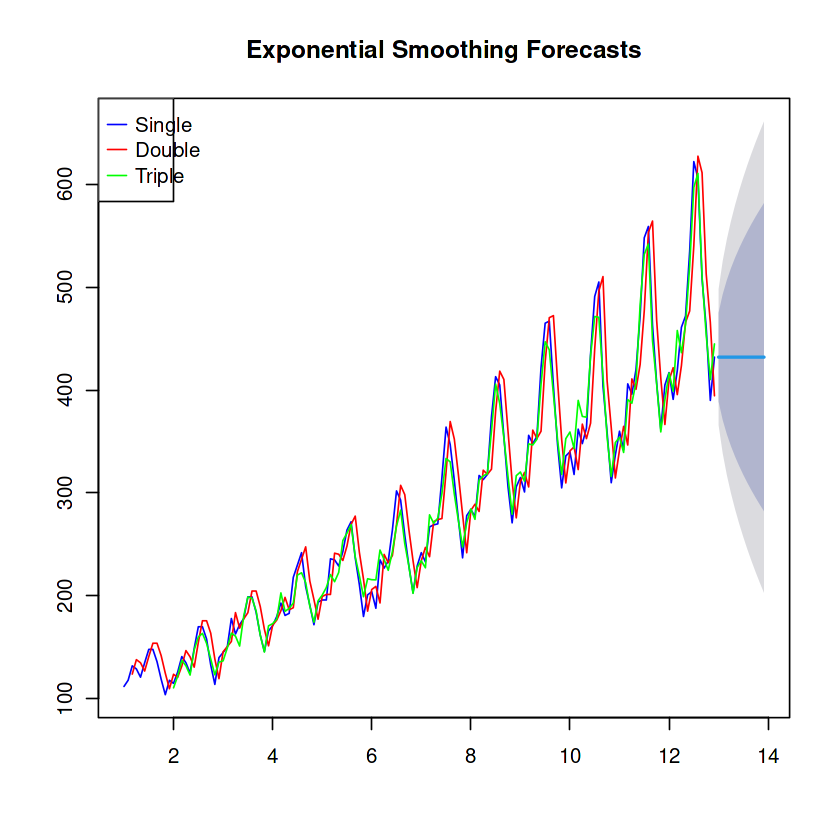

In [16]:
library(forecast)

ses_model <- HoltWinters(ts_data, beta=FALSE, gamma=FALSE)
ses_forecast <- forecast(ses_model, h=12)

des_model <- HoltWinters(ts_data, gamma=FALSE)
des_forecast <- forecast(des_model, h=12)

tes_model <- HoltWinters(ts_data)
tes_forecast <- forecast(tes_model, h=12)

plot(ses_forecast, col="blue", main="Exponential Smoothing Forecasts")
lines(des_forecast$fitted, col="red")
lines(tes_forecast$fitted, col="green")
legend("topleft", legend=c("Single", "Double", "Triple"), 
       col=c("blue", "red", "green"), lty=1)

In [17]:
library(Metrics)


calculate_metrics <- function(actual_values, predicted_values) {
  mae_value <- mae(actual_values, predicted_values)
  mse_value <- mse(actual_values, predicted_values)
  rmse_value <- rmse(actual_values, predicted_values)
  mape_value <- mean(abs((actual_values - predicted_values) / actual_values)) * 100
  
  return(list(MAE = mae_value, MAPE = mape_value, MSE = mse_value, RMSE = rmse_value))
}

forecast_periods <- 12
actual_values <- tail(df$value, forecast_periods)


# forecast_single <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)
# forecast_double <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)
# forecast_triple <- as.numeric(forecast(sample_df, h = forecast_periods)$mean)


Attaching package: ‘Metrics’


The following object is masked from ‘package:forecast’:

    accuracy




Question 3.8: Compare accuracy metrics (MAE, MAPE, MSE, RMSE) of the three models with the original series.

In [18]:

calculate_metrics <- function(actual, forecast) {
    
    fitted_values <- forecast$fitted
    
    mae <- mean(abs(actual - fitted_values))
    mse <- mean((actual - fitted_values)^2)
    rmse <- sqrt(mse)
    mape <- mean(abs((actual - fitted_values)/actual)) * 100
    
    return(data.frame(
        MAE = mae,
        MSE = mse,
        RMSE = rmse,
        MAPE = mape
    ))
}

metrics_ses <- calculate_metrics(ts_data, ses_model)
metrics_des <- calculate_metrics(ts_data, des_model)
metrics_tes <- calculate_metrics(ts_data, tes_model)


metrics_df <- rbind(
    cbind(Model = "Single ES", metrics_ses),
    cbind(Model = "Double ES", metrics_des),
    cbind(Model = "Triple ES", metrics_tes)
)

print(metrics_df)

library(knitr)
kable(metrics_df, digits = 2, 
      caption = "Comparison of Exponential Smoothing Models")

      Model       MAE       MSE      RMSE      MAPE
1 Single ES  25.86061  1136.437  33.71109  9.019603
2 Double ES 109.76023 31128.369 176.43234 38.636723
3 Triple ES 155.89231 48415.761 220.03582 53.178297




Table: Comparison of Exponential Smoothing Models

|Model     |    MAE|      MSE|   RMSE|  MAPE|
|:---------|------:|--------:|------:|-----:|
|Single ES |  25.86|  1136.44|  33.71|  9.02|
|Double ES | 109.76| 31128.37| 176.43| 38.64|
|Triple ES | 155.89| 48415.76| 220.04| 53.18|

### inference
This indicates that SES provides the best fit for the data, meaning it's able to capture the patterns with minimal error. DES and TES perform worse, suggesting that introducing trend and seasonal adjustments leads to overfitting or introduces noise, increasing errors. This implies the dataset may not contain clear trend or seasonal components.

## Time Series Forecasting using Statistical Models

• Before we apply models for forecasting, we need to create a training and validation/test set, as would
be the procedure for most machine learning problems. \
• However, one thing to keep in mind while performing this split for time series data: NEVER perform
a random split.

Question 3.9: Why do you think we shouldn’t perform a random split on our data to create a train/test/dev set?

Random splitting should not be used for time series data because:

1. Time series data uses past values to determine the prediction/forecasting of future values.
2. Random splitting would break the sequential nature of the data
3. It would make it impossible to capture seasonal patterns and trends

Question 3.10: Implement AR, MA and ARMA models, with the optimal values of p and q as calculated from PACF and ACF plots previously. \
Plot the graph between forecasts and true values.

> Hint: Look at ARMA function in forecast library

In [19]:
library(tsibble)
library(rsample)

Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following object is masked from ‘package:zoo’:

    index


The following objects are masked from ‘package:base’:

    intersect, setdiff, union




In [21]:
df_tsibble <- df %>% 
  as_tsibble(index = month) 

In [32]:
# Define the number of splits and sizes
n_splits <- 2
train_size <- 100
test_size <- 40

# Initialize Time Series Split
ts_split <- rolling_origin(df_tsibble, 
                           initial = train_size, 
                           assess = test_size,
                           skip = 1) 

# Create a list to store splits
splits <- list()

# Perform the split
for (split in ts_split$splits) {
  train <- analysis(split)
  test <- assessment(split)
  splits <- append(splits, list(list(train = train, test = test)))
}

# Extract the first (and only) train-test split
first_split <- splits[[1]]
train <- first_split$train
test <- first_split$test

Example:  
ar_model <- Arima(train, order = c(p, 0, 0)) \
ar_forecast <- forecast(ar_model, h = length(test_ts))

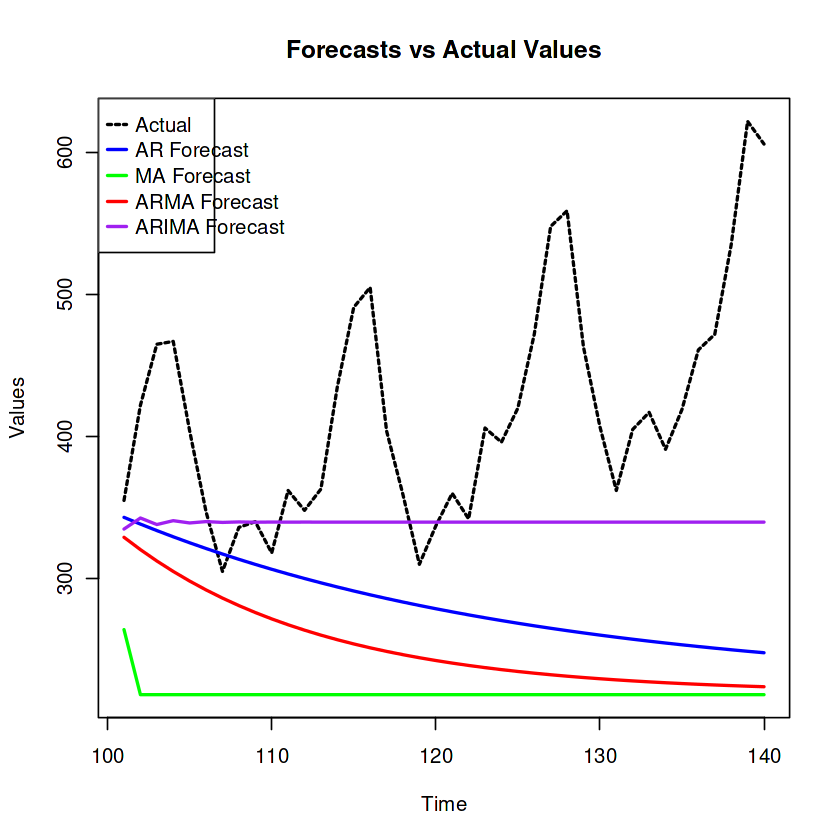

In [35]:
library(forecast)

train_values <- train$value  
test_values <- test$value    

ar_model <- Arima(train_values, order=c(1,0,0))
ar_forecast <- forecast(ar_model, h=length(test_values))

ma_model <- Arima(train_values, order=c(0,0,1))
ma_forecast <- forecast(ma_model, h=length(test_values))

arma_model <- Arima(train_values, order=c(1,0,1))
arma_forecast <- forecast(arma_model, h=length(test_values))

arima_model <- Arima(train_values, order=c(1,1,1))
arima_forecast <- forecast(arima_model, h=length(test_values))

time_index <- (length(train_values) + 1):(length(train_values) + length(test_values))

y_limits <- range(c(test_values, ar_forecast$mean, ma_forecast$mean, arma_forecast$mean, arima_forecast$mean))

plot(time_index, test_values, type="l", col="black", lty=2, lwd=2, ylim=y_limits, 
     ylab="Values", xlab="Time", main="Forecasts vs Actual Values")

lines(time_index, ar_forecast$mean, col="blue", lwd=2)
lines(time_index, ma_forecast$mean, col="green", lwd=2)
lines(time_index, arma_forecast$mean, col="red", lwd=2)
lines(time_index, arima_forecast$mean, col="purple", lwd=2)

legend("topleft", legend=c("Actual", "AR Forecast", "MA Forecast", "ARMA Forecast", "ARIMA Forecast"),
       col=c("black", "blue", "green", "red", "purple"), lty=c(2, 1, 1, 1, 1), lwd=2)


Question 3.11 : Implement the ARIMA model, with the optimal values of p, d, q as calculated from PACF and ACF plots previously. \
Plot the graph between forecasts and true values.

In [ ]:
# answered in 3.10

Question 3.11: 

1. Which models performed better? The exponential smoothing models, or the statistical models (AR, MA, ARMA, ARIMA). Why? 
2. Is this always the case? 
3. Do you think you’d get a better result if you used SARIMA? 

1) 
a) The data shows clear:
       upward trend and seasonality

b) Triple Exponential Smoothing and ARIMA can capture:
   - Level changes
   - Trend components
   - Seasonal variations
   - Non-constant variance

2) 
No, model performance varies depending on the data characteristics:

a) Simple models (Single ES, AR, MA) might perform better when:
       no trend/seasonality components
b) Complex models (ARIMA, Triple ES) are better when:
       there are trends and seasonality components
   

3) 
Yes, SARIMA would perform better for this specific dataset because

a) The air passenger data shows seasonality

b) SARIMA explicitly models seasonal components


## SARIMA

Question 3.12: Implement the SARIMA model, with the optimal values of p, d, q as calculated from PACF and ACF plots previously. \
Use Seasonal Order=(2, 1, 0, 12) \
Plot the graph between forecasts and true values.

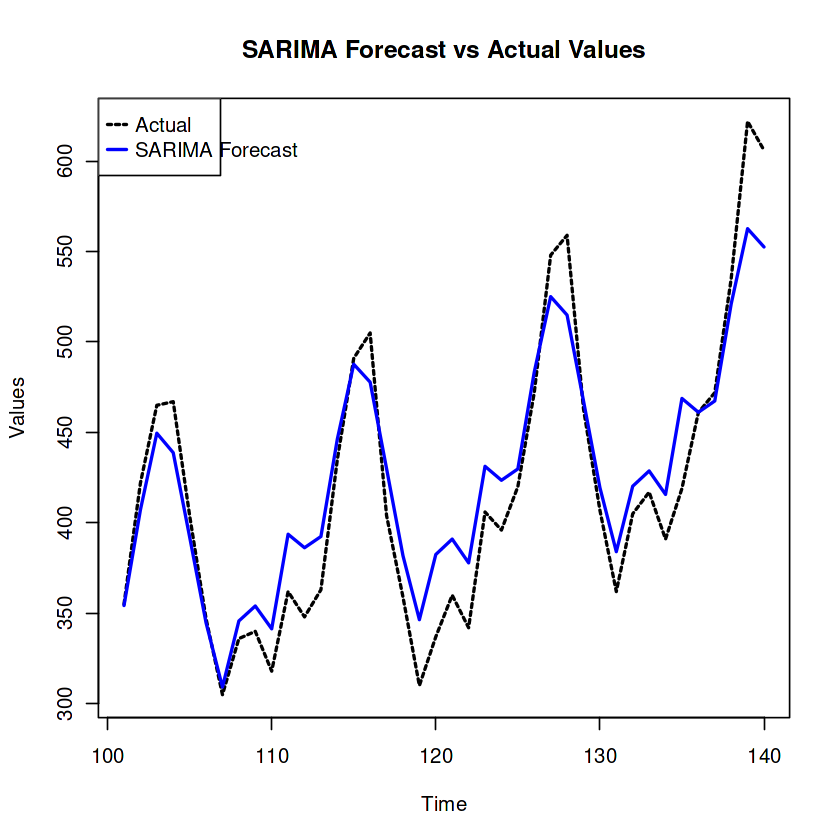

In [39]:

library(forecast)

sarima_model <- Arima(train$value, 
                      order=c(1,1,2),
                      seasonal=list(order=c(2, 1, 0), period=12)) 


sarima_forecast <- forecast(sarima_model, h=length(test$value))

time_index <- (length(train$value) + 1):(length(train$value) + length(test$value))

y_limits <- range(c(test$value, sarima_forecast$mean))

plot(time_index, test$value, type="l", col="black", lty=2, lwd=2, ylim=y_limits, 
     ylab="Values", xlab="Time", main="SARIMA Forecast vs Actual Values")

lines(time_index, sarima_forecast$mean, col="blue", lwd=2)

legend("topleft", legend=c("Actual", "SARIMA Forecast"),
       col=c("black", "blue"), lty=c(2, 1), lwd=2)


## Making Predictions

You have implemented multiple forecasting models, including ARIMA, SARIMA, and Exponential Smoothing, now select the **best model** and generate forecasts for the period following the training data, from the end of the training set to the end of the entire dataset.

Replace **selected_model** with the variable name of the best-performing model you have chosen. \
Note: Ensure that selected_model is replaced with the actual model variable you have selected after fitting and evaluating your models. This code will generate and plot forecasts using the chosen model, allowing you to compare them against the actual values from the test dataset.

### My best model
Since seasonality exists in the dataset, SARIMA is best

Provide the code for the selected model and then uncomment the following cells one by one to make predictions, forecast, and plot the graphs.

In [41]:
summary(sarima_model)

Series: train$value 
ARIMA(1,1,1)(2,1,0)[12] 

Coefficients:
         ar1     ma1     sar1    sar2
      -0.604  0.3835  -0.2020  0.0283
s.e.   0.304  0.3502   0.1123  0.1221

sigma^2 = 92.81:  log likelihood = -318.8
AIC=647.59   AICc=648.33   BIC=659.92

Training set error measures:
                  ME    RMSE      MAE       MPE     MAPE      MASE        ACF1
Training set 0.46483 8.77693 6.358875 0.1422383 2.844059 0.3380927 -0.01565805

In [42]:
train_prediction <- fitted(sarima_model)

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


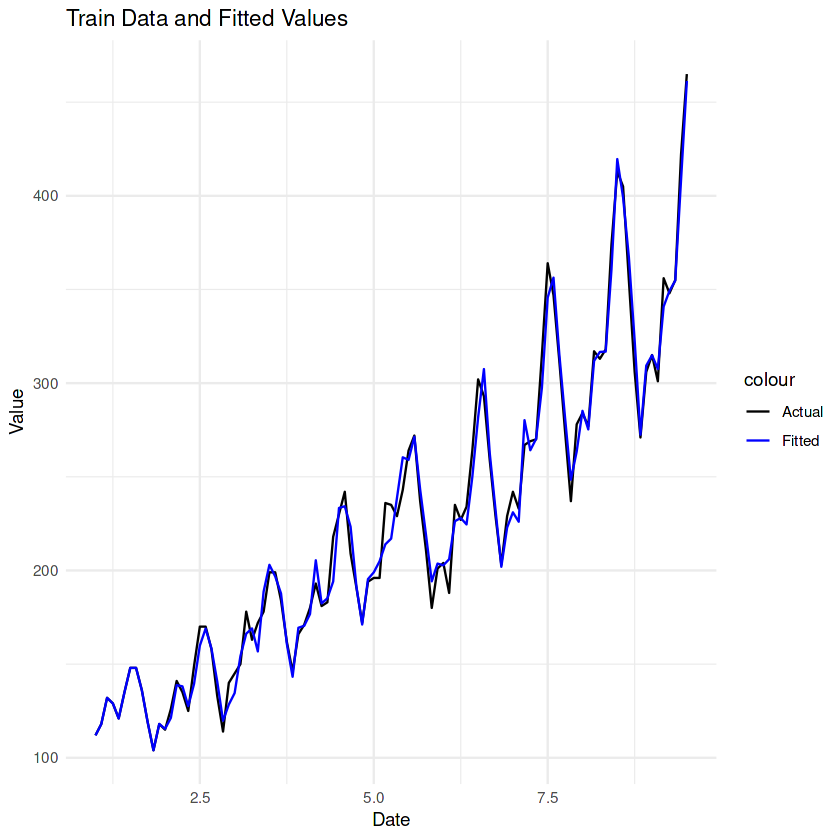

In [43]:

df_ts <- ts(df$value, frequency=12) 

train_size <- floor(0.8 * length(df_ts)) 
train_ts <- window(df_ts, end=c(floor(train_size/12), train_size%%12))

sarima_model <- Arima(train_ts, 
                     order=c(1,1,1),
                     seasonal=list(order=c(2,1,0), period=12))

train_prediction <- fitted(sarima_model)

plot_data <- data.frame(
    Date = time(train_ts),
    Actual = as.numeric(train_ts),
    Fitted = as.numeric(train_prediction)
)

ggplot(plot_data, aes(x = Date)) +
    geom_line(aes(y = Actual, color = "Actual")) +
    geom_line(aes(y = Fitted, color = "Fitted")) +
    labs(title = "Train Data and Fitted Values",
         x = "Date", y = "Value") +
    scale_color_manual(values = c("Actual" = "black", "Fitted" = "blue")) +
    theme_minimal()

In [44]:
df_ts <- ts(df$value, frequency = 12)

In [45]:
 start_index <- length(train_ts) + 1
 end_index <- length(df_ts)


 prediction <- forecast(sarima_model, h = (end_index - start_index + 1))

 prediction_df <- data.frame(prediction = as.numeric(prediction$mean))

 prediction_df$Date <- time(df_ts)[start_index:end_index]

 print(prediction_df)

   prediction      Date
1    455.2738  9.583333
2    407.6098  9.666667
3    360.1169  9.750000
4    323.9583  9.833333
5    361.0544  9.916667
6    369.0374 10.000000
7    356.4075 10.083333
8    409.1830 10.166667
9    401.4825 10.250000
10   408.3997 10.333333
11   474.2187 10.416667
12   515.8468 10.500000
13   507.0277 10.583333
14   457.9469 10.666667
15   409.4513 10.750000
16   373.6295 10.833333
17   409.9561 10.916667
18   418.3184 11.000000
19   404.9785 11.083333
20   459.1511 11.166667
21   451.1294 11.250000
22   458.1955 11.333333
23   524.9604 11.416667
24   567.0971 11.500000
25   558.0034 11.583333
26   509.3273 11.666667
27   461.1081 11.750000
28   425.1496 11.833333
29   461.7516 11.916667
30   469.9792 12.000000
31   456.8555 12.083333
32   510.6344 12.166667
33   502.6890 12.250000
34   509.7235 12.333333
35   576.2437 12.416667
36   618.1993 12.500000
37   609.2146 12.583333
38   560.3725 12.666667
39   512.0377 12.750000
40   476.1257 12.833333
41   512.6278 12

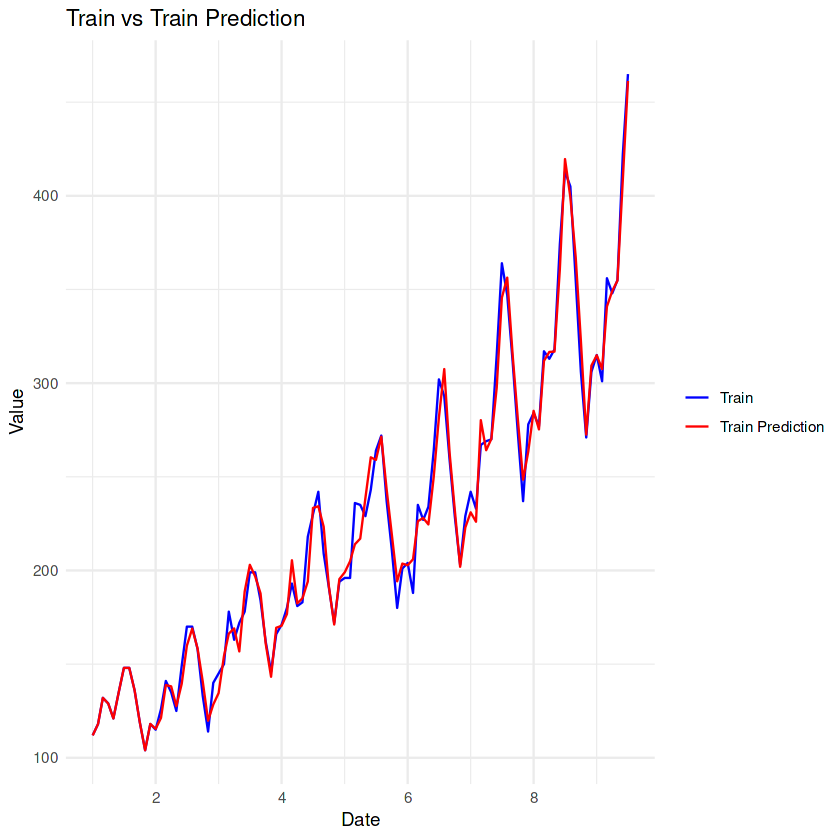

In [46]:
# 
 train_df <- data.frame(
   Date = as.Date(time(train_ts), origin = "1970-01-01"), 
   Value = as.numeric(train_ts),  
   Type = "Train"
 )

 train_prediction_df <- data.frame(
   Date = as.Date(time(train_prediction), origin = "1970-01-01"), 
   Value = as.numeric(train_prediction),
   Type = "Train Prediction"
 )

 plot_data <- rbind(train_df, train_prediction_df)

 ggplot(plot_data, aes(x = Date, y = Value, color = Type)) +
   geom_line() +
   labs(title = "Train vs Train Prediction",
        x = "Date", y = "Value") +
   scale_color_manual(values = c("Train" = "blue", "Train Prediction" = "red")) +
   theme_minimal() + 
   theme(legend.title = element_blank())

Congratulations on reaching the end of this worksheet! I hope you enjoyed it, and have an understanding of how practical time series analysis works.

Some advanced concepts for you to explore are listed below:

* One of the main errors of dealing with time-series data includes preventing lookahead. It’s extremely
important that you aren’t looking at future values to predict earlier ones. You can read more about it
here: https://bowtiedraptor.substack.com/p/look-ahead-bias-and-how-to-prevent
* Although the dataset provided to you for this worksheet was cleaned prior, real world data is extremely
dirty. Time series data especially tends to contain quite a few missing values. Try to explore some
ways of taking care of missing values in data. Some techniques include imputation, forward fills,
interpolation, moving averages, etc.
* Understanding some Classical Machine Learning techniques for Time Series Forecasting, such as Decision
Trees, Forests, Feed-forward Neural Networks, etc.
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/ \
https://www.section.io/engineering-education/feedforward-and-recurrent-neural-networks-pythonimplementation/